<a href="https://colab.research.google.com/github/joaomarcosmb/ml-ufc/blob/main/lista-04/AMA_Lista_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform, loguniform, randint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

In [2]:
def dataset_split(X, y, val_size=0.2, test_size=0.2, shuffle=True, random_state=42):
  if val_size + test_size >= 1.0:
    raise ValueError("A soma de val_size e test_size deve ser menor que 1.0")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                      random_state=random_state,
                                                      shuffle=shuffle)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=val_size / (1 - test_size),
                                                    random_state=random_state,
                                                    shuffle=shuffle)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
def regressionMetrics(y_true, y_pred):
    # RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    # MAE
    mae = np.mean(np.abs(y_true - y_pred))
    # MRE
    mre = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mre

In [4]:
def hyperparameter_optimization(X_train, y_train, X_val, y_val, task, seed=42,
                                epochs=2000, batch_size=32, n_trials=10,
                                verbose=False):
    if task not in ["regression", "classification"]:
        raise ValueError("Tarefa deve ser 'regression' ou 'classification'.")

    rng_search = np.random.default_rng(seed)

    best_val_loss = np.inf        # Infinito positivo
    best_params = None

    n_outputs = y_train.shape[1] if y_train.ndim > 1 else 1

    search_epochs = 1000

    for trial in range(n_trials):
        n_hidden = rng_search.integers(10, 200)
        learning_rate = 10 ** rng_search.uniform(-4, -1)   # Log-uniform
        momentum = rng_search.uniform(0.5, 0.95)

        mlp = MLP(
            n_inputs=X_train.shape[1],
            n_hidden=n_hidden,
            n_outputs=n_outputs,
            task=task,
            learning_rate=learning_rate,
            momentum=momentum,
            random_state=seed + trial,
        )

        try:
            _, history_val = mlp.fit(
                X_train,
                y_train,
                X_val,
                y_val,
                epochs=search_epochs,
                batch_size=batch_size,
                verbose=False,
            )

            # Pega a média das últimas 10 épocas para evitar ruído estocástico
            val_loss = np.mean(history_val[-10:])
        except Exception as e:
            val_loss = np.inf

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {
                "n_hidden": n_hidden,
                "learning_rate": learning_rate,
                "momentum": momentum,
            }

    best_model = MLP(
        n_inputs=X_train.shape[1],
        n_hidden=best_params["n_hidden"],
        n_outputs=y_train.shape[1] if y_train.ndim > 1 else 1,
        task=task,
        learning_rate=best_params["learning_rate"],
        momentum=best_params["momentum"],
        random_state=seed,
    )

    best_history_train, best_history_val = best_model.fit(
        X_train,
        y_train,
        X_val,
        y_val,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
    )

    return best_params, best_model, best_history_train, best_history_val, best_val_loss

Os pesos amostrados serão iniciados seguindo a seguinte regra:
$$
\sqrt{\frac{1}{N_{in}}} \mathcal{N}(0, 1),
$$
Onde $N_{in}$ é o número de entradas do neurônio.

## Algoritmo de backpropagation
### Sentido forward
1. Saída do j-ésimo neurônio da camda oculta para a entrada $\boldsymbol{x}$:
$$
z_j = \phi_1(u_j), \quad u_j = \boldsymbol{w}_j^\top \boldsymbol{x}, \quad 1 \leq j \leq N_H
$$
2. Saída do k-ésimo neurônio da camada de saída:
$$
o_k = \phi_2(r_k), \quad r_k = \boldsymbol{m}_k^\top \boldsymbol{z}, 1 \leq k \leq K
$$

### Sentido backward
1. Calcular os gradientes da função de custo na camada de saída;
2. Retropropagar os erros para a camada oculta (regra da cadeia);
3. E atualizar todos os pesos via SGD.

# Questão 1

In [5]:
class MLP:
    def __init__(
        self,
        n_inputs: int,
        n_hidden: int | list[int],
        n_outputs: int,
        task: str = "regression",
        learning_rate: float = 0.01,
        momentum: float = 0.9,
        random_state: int | None = None,
    ):
        """ Notação:
        W: matriz de pesos da camada oculta
        M: matriz de pesos da camada de saída
        X: matriz de entradas
        Z: matriz de saídas da camada oculta
        R: matriz de saídas da camada de saída
        Y: matriz de saídas desejadas
        O: matriz de saídas obtidas
        """
        self.n_inputs = n_inputs

        if np.isscalar(n_hidden):
            self.n_hidden = [int(n_hidden)]
        else:
            self.n_hidden = list(n_hidden)

        self.H = len(self.n_hidden)                 # número de camadas ocultas

        self.n_outputs = n_outputs
        self.task = task
        self.learning_rate = learning_rate
        self.momentum = momentum

        # Inicializa gerador de números aleatórios
        self.rng = np.random.default_rng(random_state)

        # Pesos das camadas ocultas
        self.W = []
        self.b = []
        self.vW = []
        self.vb = []

        in_dim = self.n_inputs
        for n_units in self.n_hidden:
            # Inicializa a matriz de pesos com valores pequenos aleatórios
            W_h = self.rng.normal(
                loc=0.0,
                scale=np.sqrt(1 / in_dim),          # Média da distribuição
                size=(in_dim, n_units),             # Desvio padrão da distribuição
            )
            b_h = np.zeros(n_units)

            self.W.append(W_h)
            self.b.append(b_h)
            self.vW.append(np.zeros_like(W_h))
            self.vb.append(np.zeros_like(b_h))

            in_dim = n_units

        # Camada de saída
        self.M = self.rng.normal(
            loc=0.0,
            scale=np.sqrt(1 / in_dim),
            size=(in_dim, self.n_outputs),
        )
        self.bM = np.zeros(self.n_outputs)

        self.vM = np.zeros_like(self.M)
        self.vbM = np.zeros_like(self.bM)

        # Define explicitamente o tipo para o Scikit-Learn
        if self.task == "classification":
            self._estimator_type = "classifier"
        else:
            self._estimator_type = "regressor"

    @staticmethod
    def _sigmoid(z: np.ndarray) -> np.ndarray:
        """Calcula a função logística elemento a elemento."""
        return 1.0 / (1.0 + np.exp(-z))

    @staticmethod
    def _sigmoid_deriv(a: np.ndarray) -> np.ndarray:
        """Derivada da sigmoide baseada no valor já ativado."""
        return a * (1.0 - a)

    @staticmethod
    def _softmax(r: np.ndarray) -> np.ndarray:
        """Calcula a função softmax linha a linha para um array 2D.

        Subtrai o máximo de cada linha para melhorar a estabilidade
        numérica.
        """
        r_shift = r - np.max(r, axis=1, keepdims=True)
        exp_r = np.exp(r_shift)
        return exp_r / np.sum(exp_r, axis=1, keepdims=True)

    def _forward(self, X: np.ndarray) -> tuple[list[np.ndarray], np.ndarray, np.ndarray]:
        """Propaga as entradas ``X`` pela rede e retorna valores intermediários."""
        Z_list = []
        Z_prev = X

        # ----- Camadas ocultas -----
        for W_h, b_h in zip(self.W, self.b):
            U_h = Z_prev @ W_h + b_h
            Z_h = self._sigmoid(U_h)
            Z_list.append(Z_h)
            Z_prev = Z_h

        # ----- Camada de saída -----
        R = Z_prev @ self.M + self.bM

        # A função de ativação da camada de saída depende do tipo de tarefa
        if self.task == "regression":
            O = R                 # Ativação linear
        elif self.task == "classification":
            O = self._softmax(R)  # Ativação softmax
        else:
            raise ValueError(f"Tarefa desconhecida: {self.task}.")

        return Z_list, R, O

    def _compute_loss(self, Y: np.ndarray, O: np.ndarray) -> float:
        """Calcula a função custo média de acordo com a tarefa."""
        if self.task == "regression":       # MSE
            return 0.5 * np.mean((Y - O) ** 2)
        elif self.task == "classification": # Multiclass Cross-Entropy Loss
            # Adiciona pequeno termo para estabilidade numérica
            epsilon = 1e-12
            return -np.mean(np.sum(Y * np.log(O + epsilon), axis=1))
        return 0.0

    def _backward(
        self,
        X: np.ndarray,
        Y: np.ndarray,
        Z_list: list[np.ndarray],
        O: np.ndarray,
    ) -> tuple[list[np.ndarray], list[np.ndarray], np.ndarray, np.ndarray]:
        """Executa a etapa de retropropagação e retorna os gradientes."""
        N = X.shape[0]                            # Tamanho do minibatch
        H = len(Z_list)                           # Número de camadas ocultas

        # ----- Camada de saída -----
        delta = (O - Y) / N                      # Válido para MSE e Softmax + CE

        Z_H = Z_list[-1]
        dM = Z_H.T @ delta
        dbM = np.sum(delta, axis=0)

        # ----- Camadas ocultas -----
        zeta_list = [None] * H

        # h = H (última camada oculta)
        zeta = (delta @ self.M.T) * self._sigmoid_deriv(Z_H)
        zeta_list[-1] = zeta

        # h = H - 1, ..., 1
        for h in range(H - 2, -1, -1):
            zeta = (zeta_list[h + 1] @ self.W[h + 1].T) * self._sigmoid_deriv(Z_list[h])
            zeta_list[h] = zeta

        # Atualização dos gradientes
        dW_list = []
        db_list = []

        for h in range(H):
            Z_prev = X if h == 0 else Z_list[h - 1]
            zeta_h = zeta_list[h]
            dW_h = Z_prev.T @ zeta_h
            db_h = np.sum(zeta_h, axis=0)

            dW_list.append(dW_h)
            db_list.append(db_h)

        return dW_list, db_list, dM, dbM

    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        y_val: np.ndarray,
        epochs: int = 200,
        batch_size: int = 32,
        verbose: bool = False,
    ) -> tuple[list[float], list[float]]:
        """Treina a rede neural.

        Durante o treinamento, o método armazena a evolução da função
        custo para os conjuntos de treino e validação. Esses valores
        são retornados para permitir a plotagem posterior.
        """
        if self.task == "classification":
            self.classes_ = np.arange(self.n_outputs)

        history_train = []
        history_val = []
        N = X_train.shape[0]

        for epoch in range(epochs):
            # Embaralha os índices do conjunto de treino para SGD
            indices = self.rng.permutation(N)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Processa cada minibatch
            for start_idx in range(0, N, batch_size):
                end_idx = start_idx + batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Forward pass
                Z_batch, _, O_batch = self._forward(X_batch)

                # Backward pass
                dW_list, db_list, dM, dbM = self._backward(
                    X_batch, y_batch, Z_batch, O_batch
                )

                # ------- Momentum -------
                # Camadas ocultas
                for h in range(self.H):
                    self.vW[h] = self.momentum * self.vW[h] - self.learning_rate * dW_list[h]
                    self.vb[h] = self.momentum * self.vb[h] - self.learning_rate * db_list[h]

                    self.W[h] += self.vW[h]
                    self.b[h] += self.vb[h]

                # Camada de saída (M)
                self.vM = self.momentum * self.vM - self.learning_rate * dM
                self.vbM = self.momentum * self.vbM - self.learning_rate * dbM

                self.M += self.vM
                self.bM += self.vbM

            # Após processar todos os minibatches, avalia o custo total
            _, _, O_train = self._forward(X_train)
            loss_train = self._compute_loss(y_train, O_train)
            history_train.append(loss_train)

            # Avalia custo no conjunto de validação
            _, _, O_val = self._forward(X_val)
            loss_val = self._compute_loss(y_val, O_val)
            history_val.append(loss_val)

            if verbose and ((epoch + 1) % 10 == 0 or epoch == 0):
                print(f"Época {epoch + 1}/{epochs} | Custo treino: {loss_train:.4f} | Custo val: {loss_val:.4f}")

        return history_train, history_val

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Gera previsões da rede para novos dados.

        Para regressão, retorna um vetor com valores contínuos. Para
        classificação, retorna o índice da classe com maior probabilidade.
        """
        _, _, O = self._forward(X)
        if self.task == "classification":
            return np.argmax(O, axis=1)
        else:
            return O.squeeze()

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Retorna as probabilidades estimadas para cada classe."""
        _, _, O = self._forward(X)
        return O

In [6]:
# Carregamento do dataset
concrete_df = pd.read_csv("concrete.csv")
X = concrete_df.iloc[:, :-1].values
y = concrete_df.iloc[:, -1].values
y = y.reshape(-1, 1)

In [7]:
# Split dos dados em treino, validação e teste
X_train, X_val, X_test, y_train, y_val, y_test = dataset_split(X, y, val_size=0.2, test_size=0.2, shuffle=True, random_state=42)

# Normalização dos dados de entrada
scaler_X = StandardScaler()
X_train_norm = scaler_X.fit_transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

# Normalização dos dados de saída
scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)


--------- Treino ---------
RMSE: 3.5479
MAE: 2.6222
MRE: 9.2651

--------- Validação ---------
RMSE: 4.5693
MAE: 3.4702
MRE: 12.4819

--------- Teste ---------
RMSE: 5.5424
MAE: 3.8066
MRE: 13.2194



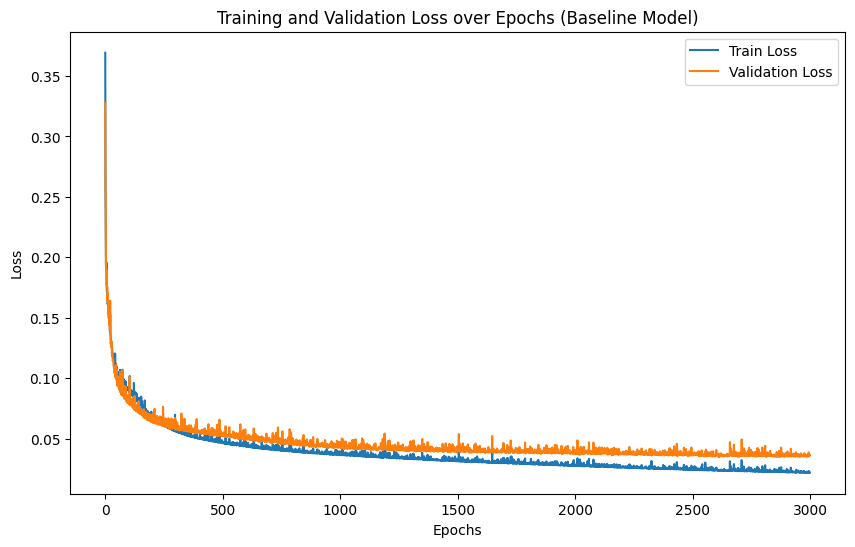

In [8]:
# Modelo baseline
concrete_baseline_model = MLP(
    n_inputs=X_train_norm.shape[1],
    n_hidden=50,
    n_outputs=1,
    task="regression",
    learning_rate=0.01,
    momentum=0.9,
    random_state=42
)

history_train, history_val = concrete_baseline_model.fit(
    X_train_norm,
    y_train_norm,
    X_val_norm,
    y_val_norm,
    epochs=3000,
    batch_size=32,
    verbose=False
)

y_train_pred_norm = concrete_baseline_model.predict(X_train_norm)
y_val_pred_norm = concrete_baseline_model.predict(X_val_norm)
y_test_pred_norm = concrete_baseline_model.predict(X_test_norm)

# Desnormalização para o cálculo de métricas
y_train_pred = scaler_y.inverse_transform(y_train_pred_norm.reshape(-1, 1))
y_val_pred = scaler_y.inverse_transform(y_val_pred_norm.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred_norm.reshape(-1, 1))

rmse_train, mae_train, mre_train = regressionMetrics(y_train, y_train_pred)
rmse_val, mae_val, mre_val = regressionMetrics(y_val, y_val_pred)
rmse_test, mae_test, mre_test = regressionMetrics(y_test, y_test_pred)
print(f"""
--------- Treino ---------
RMSE: {rmse_train:.4f}
MAE: {mae_train:.4f}
MRE: {mre_train:.4f}

--------- Validação ---------
RMSE: {rmse_val:.4f}
MAE: {mae_val:.4f}
MRE: {mre_val:.4f}

--------- Teste ---------
RMSE: {rmse_test:.4f}
MAE: {mae_test:.4f}
MRE: {mre_test:.4f}
""")

# Curva de loss
plt.figure(figsize=(10, 6))
plt.plot(history_train, label='Train Loss')
plt.plot(history_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Baseline Model)')
plt.legend()
plt.show()

In [9]:
# Otimização dos hiperparâmetros
best_params, best_model, best_history_train, best_history_val, best_val_loss = hyperparameter_optimization(X_train=X_train_norm, y_train=y_train_norm, X_val=X_val_norm, y_val=y_val_norm, task="regression")

print(f'Best params: {best_params}')
print(f'Best validation loss: {best_val_loss}')

Best params: {'n_hidden': np.int64(53), 'learning_rate': 0.030401395269679967, 'momentum': 0.7842489796049292}
Best validation loss: 0.04115633226601348


In [10]:
y_train_pred_norm = best_model.predict(X_train_norm)
y_val_pred_norm = best_model.predict(X_val_norm)
y_test_pred_norm = best_model.predict(X_test_norm)

# Desnormalização para o cálculo de métricas
y_train_pred = scaler_y.inverse_transform(y_train_pred_norm.reshape(-1, 1))
y_val_pred = scaler_y.inverse_transform(y_val_pred_norm.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred_norm.reshape(-1, 1))

rmse_train, mae_train, mre_train = regressionMetrics(y_train, y_train_pred)
rmse_val, mae_val, mre_val = regressionMetrics(y_val, y_val_pred)
rmse_test, mae_test, mre_test = regressionMetrics(y_test, y_test_pred)
print(f"""
--------- Treino ---------
RMSE: {rmse_train:.4f}
MAE: {mae_train:.4f}
MRE: {mre_train:.4f}

--------- Validação ---------
RMSE: {rmse_val:.4f}
MAE: {mae_val:.4f}
MRE: {mre_val:.4f}

--------- Teste ---------
RMSE: {rmse_test:.4f}
MAE: {mae_test:.4f}
MRE: {mre_test:.4f}
""")


--------- Treino ---------
RMSE: 3.6659
MAE: 2.7302
MRE: 9.7186

--------- Validação ---------
RMSE: 4.7394
MAE: 3.5219
MRE: 12.1988

--------- Teste ---------
RMSE: 5.5439
MAE: 3.8486
MRE: 13.2424



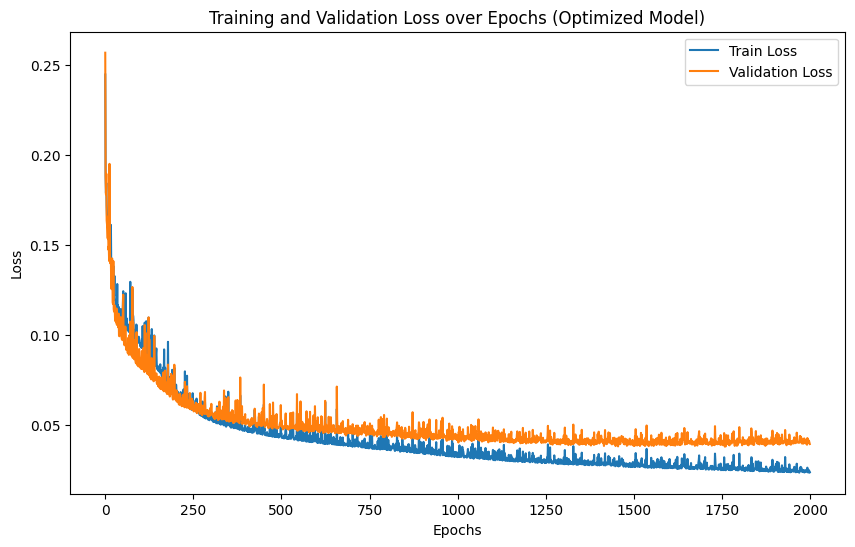

In [11]:
# Curva de loss
plt.figure(figsize=(10, 6))
plt.plot(best_history_train, label='Train Loss')
plt.plot(best_history_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Optimized Model)')
plt.legend()
plt.show()

# Questão 2

In [12]:
vowel_df = pd.read_csv("vowel.csv")
X = vowel_df.iloc[:, :-1].values
y = vowel_df.iloc[:, -1].values

# Encoding para as saídas
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

In [13]:
vowel_df.head()

,-3.638999999999999790e+00,4.179999999999999827e-01,-6.700000000000000400e-01,1.778999999999999915e+00,-1.680000000000000104e-01,1.627000000000000002e+00,-3.880000000000000115e-01,5.290000000000000258e-01,-8.739999999999999991e-01,-8.139999999999999458e-01,8.000000000000000000e+00
0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,2.0
1,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1.0
2,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,0.0
3,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,5.0
4,-2.852,1.914,-0.755,0.825,-1.588,0.855,0.217,-0.246,0.238,-0.365,6.0


In [14]:
# Split dos dados em treino, validação e teste
X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded = dataset_split(X, y_encoded, val_size=0.2, test_size=0.2, shuffle=True, random_state=42)

# Normalização dos dados de entrada
scaler_X = StandardScaler()
X_train_norm = scaler_X.fit_transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

# Recuperar labels originais para o cálculo das métricas
y_train_labels = encoder.inverse_transform(y_train_encoded).ravel()
y_val_labels = encoder.inverse_transform(y_val_encoded).ravel()
y_test_labels = encoder.inverse_transform(y_test_encoded).ravel()

------------------------------
Treino:    1.0000
Validação: 0.9141
Teste:     0.9495
------------------------------


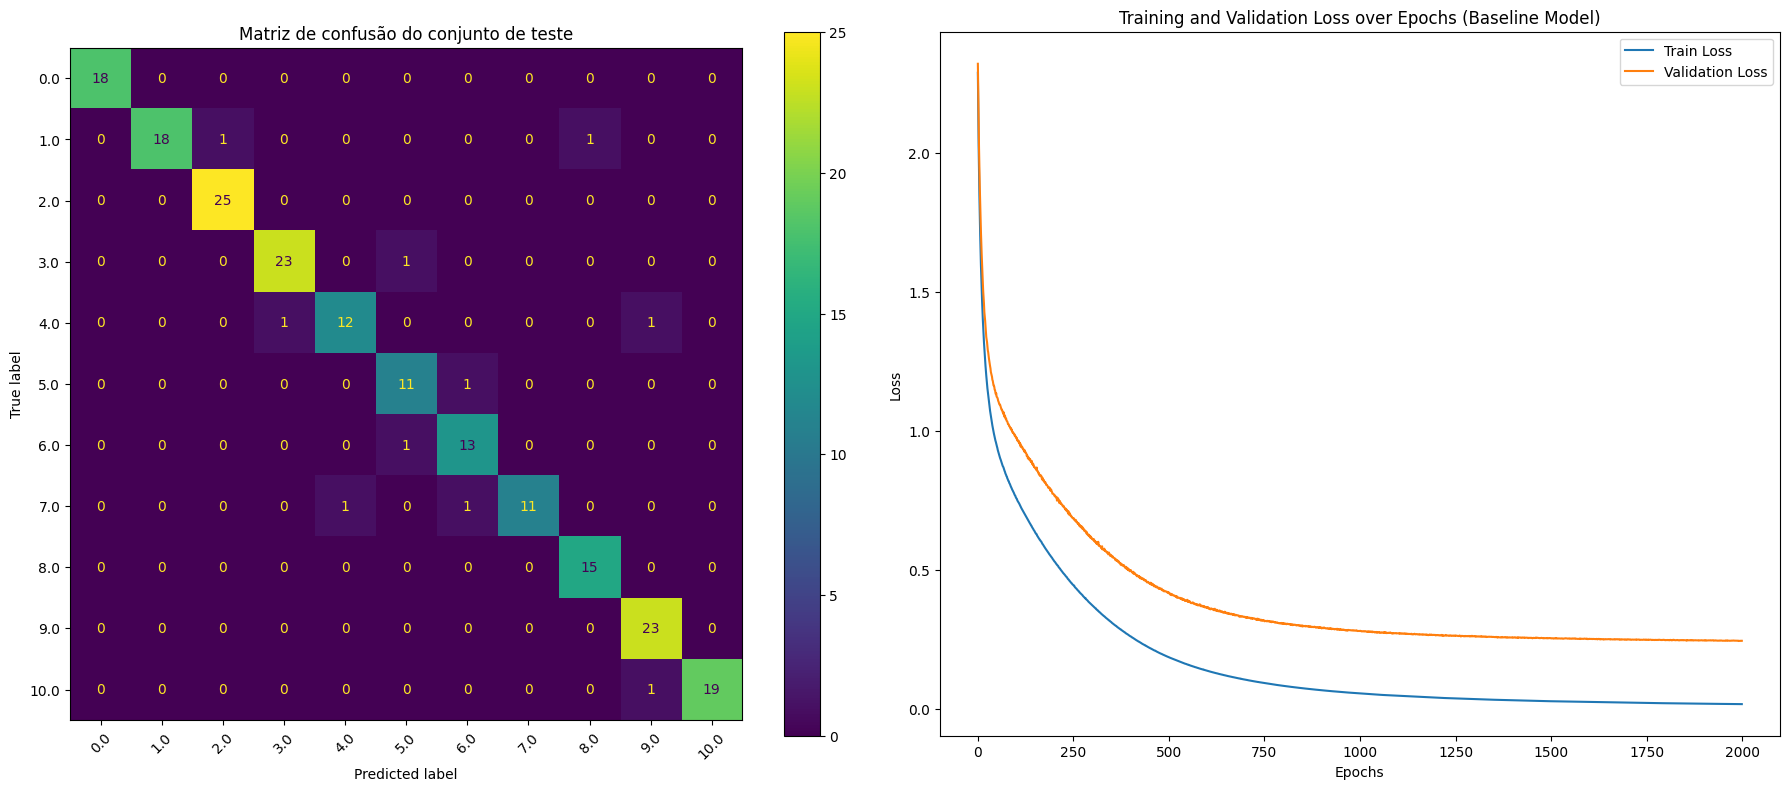

In [15]:
# Modelo baseline
vowel_baseline_model = MLP(
    n_inputs=X_train_norm.shape[1],
    n_hidden=100,
    n_outputs=11,
    task="classification",
    learning_rate=0.01,
    momentum=0.9,
    random_state=42
)

history_train, history_val = vowel_baseline_model.fit(
    X_train_norm,
    y_train_encoded,
    X_val_norm,
    y_val_encoded,
    epochs=2000,
    batch_size=32,
    verbose=False
)


y_train_pred_encoded = vowel_baseline_model.predict(X_train_norm)
y_val_pred_encoded = vowel_baseline_model.predict(X_val_norm)
y_test_pred_encoded = vowel_baseline_model.predict(X_test_norm)

train_pred = vowel_baseline_model.predict(X_train_norm)
val_pred = vowel_baseline_model.predict(X_val_norm)
test_pred = vowel_baseline_model.predict(X_test_norm)

y_train_idx = np.argmax(y_train_encoded, axis=1)
y_val_idx = np.argmax(y_val_encoded, axis=1)
y_test_idx = np.argmax(y_test_encoded, axis=1)

acc_train = accuracy_score(y_train_idx, train_pred)
acc_val = accuracy_score(y_val_idx, val_pred)
acc_test = accuracy_score(y_test_idx, test_pred)

print("-" * 30)
print(f"Treino:    {acc_train:.4f}")
print(f"Validação: {acc_val:.4f}")
print(f"Teste:     {acc_test:.4f}")
print("-" * 30)


fig, axes = plt.subplots(1, 2, figsize=(18, 8))

cm = confusion_matrix(y_test_idx, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=encoder.categories_[0])
disp.plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title("Matriz de confusão do conjunto de teste")

axes[1].plot(history_train, label='Train Loss')
axes[1].plot(history_val, label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss over Epochs (Baseline Model)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Otimização dos hiperparâmetros
best_params, best_model, best_history_train, best_history_val, best_val_loss = hyperparameter_optimization(X_train=X_train_norm, y_train=y_train_encoded,
                                                                                                           X_val=X_val_norm, y_val=y_val_encoded,
                                                                                                           task="classification")

print(f'Best params: {best_params}')
print(f'Best validation loss: {best_val_loss}')

Best params: {'n_hidden': np.int64(154), 'learning_rate': 0.047792897834492004, 'momentum': 0.8502725736831929}
Best validation loss: 0.2297141468544163


------------------------------
Treino:    1.0000
Validação: 0.9091
Teste:     0.9495
------------------------------


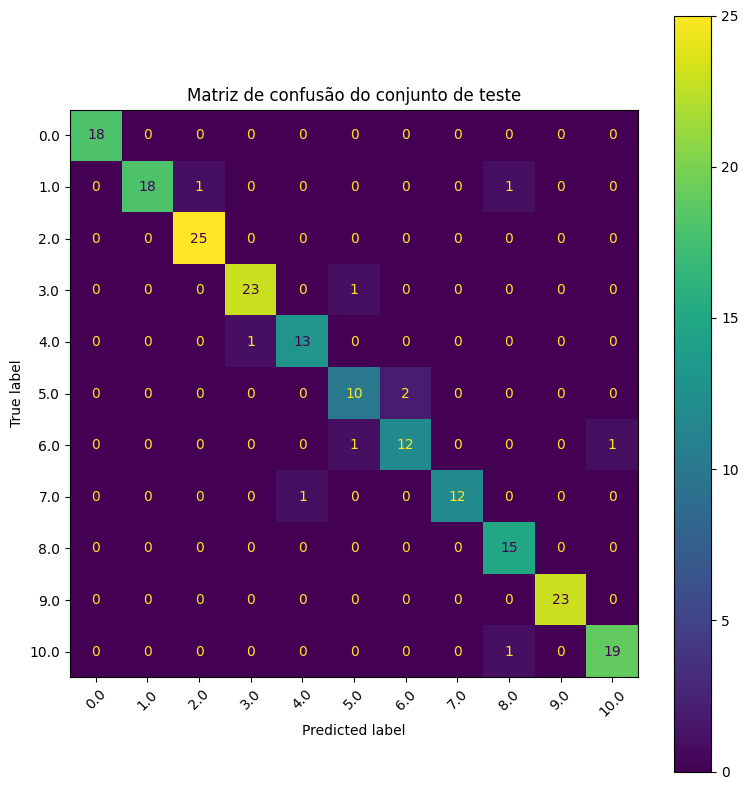

In [17]:
train_pred = best_model.predict(X_train_norm)
val_pred = best_model.predict(X_val_norm)
test_pred = best_model.predict(X_test_norm)

y_train_idx = np.argmax(y_train_encoded, axis=1)
y_val_idx = np.argmax(y_val_encoded, axis=1)
y_test_idx = np.argmax(y_test_encoded, axis=1)

acc_train = accuracy_score(y_train_idx, train_pred)
acc_val = accuracy_score(y_val_idx, val_pred)
acc_test = accuracy_score(y_test_idx, test_pred)

print("-" * 30)
print(f"Treino:    {acc_train:.4f}")
print(f"Validação: {acc_val:.4f}")
print(f"Teste:     {acc_test:.4f}")
print("-" * 30)

cm = confusion_matrix(y_test_idx, test_pred)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=encoder.categories_[0])
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Matriz de confusão do conjunto de teste")
plt.tight_layout()
plt.show()

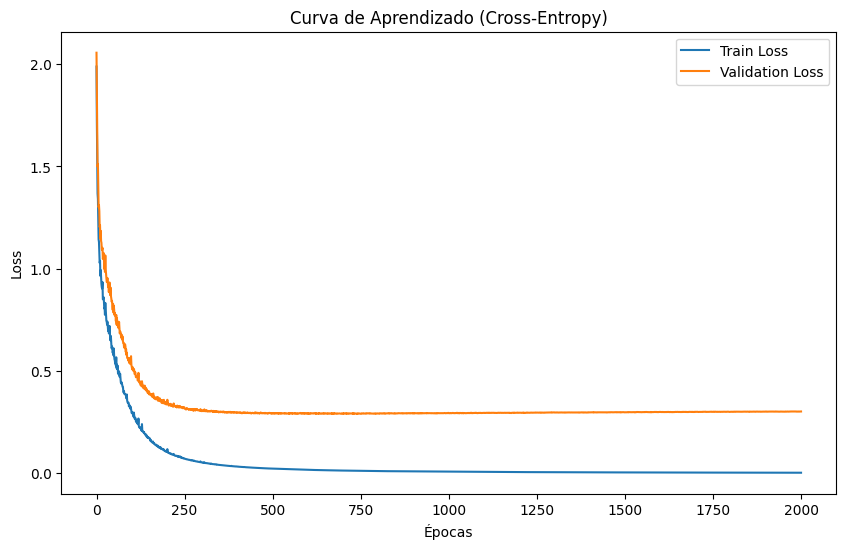

In [18]:
# Curva de loss
plt.figure(figsize=(10, 6))
plt.plot(best_history_train, label="Train Loss")
plt.plot(best_history_val, label="Validation Loss")
plt.title("Curva de Aprendizado (Cross-Entropy)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()